In [1]:
%matplotlib inline
from sklearn import linear_model
import scipy.stats
import os
import shutil
import re
import numpy as np
import pandas as pd
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt
from Bio import SeqIO
from src import contig_stats
sns.set_style("whitegrid")

In [2]:
path = "/media/NGS/Sequence/Enterococcus_faecalis/NCBI"

In [3]:
def run(args):
    fasta, file = args
    id = re.sub(r".fna$", "", file)
    n25, n50, n75, m, c = contig_stats.stats(list(SeqIO.parse(fasta, "fasta")))
    return id, n25, n50, n75, m, c

In [4]:
args = ((os.path.join(path, file), file) for file in os.listdir(path))
data = list(ProcessPoolExecutor(25).map(run, args, chunksize=50))

In [5]:
table = pd.DataFrame(data, columns=["id", "N25", "N50", "N75", "total_length", "counts"])
table.shape

(1442, 6)

In [6]:
identify = pd.read_csv('/media/NGS/Sequence/Enterococcus_faecalis/Identify.csv', index_col=0)
identify = identify[identify['Species'] == 'Enterococcus faecalis']

table = pd.merge(table, identify, left_on='id', right_index=True)
table.head()

,id,N25,N50,N75,total_length,counts,Query_Coverage,Template_Coverage,Species
0,GCA_000392775.1,1617975,883017,883017,3274276,8,84.44,93.60,Enterococcus faecalis
1,GCA_000395285.1,1493029,1493029,431944,2919956,10,88.60,86.23,Enterococcus faecalis
2,GCA_000647995.1,148960,61993,35781,2935294,98,76.70,76.56,Enterococcus faecalis
3,GCA_901521655.1,271824,189086,85986,3426145,107,86.43,92.50,Enterococcus faecalis
4,GCA_000391665.1,1526515,1526515,336519,2904349,9,79.67,74.16,Enterococcus faecalis


# Combine metadata selection

In [7]:
metafile = "/media/NGS/Sequence/Enterococcus_faecalis/METADATA.csv"
meta = pd.read_csv(metafile)
meta = meta[meta["GC%"] != "-"]
meta["GC%"] = meta['GC%'].astype(float)

/home/chen1i6c04/.conda/envs/Notebook/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [15]:
meta['Assembly'] = meta['Assembly'].str.strip()

In [16]:
curated = pd.merge(table, meta, left_index=True, left_on='id', right_on="Assembly")

In [17]:
def fence(df, subset):
    std = curated[subset].std()
    mean = curated[subset].mean()
    return (curated[subset]>(mean - 2*std))&(curated[subset]<(mean + 2*std))

In [18]:
curated['outlier'] = ~(fence(curated, 'GC%') & fence(curated, 'Size (Mb)'))
curated[~curated['outlier']].shape

(1389, 29)

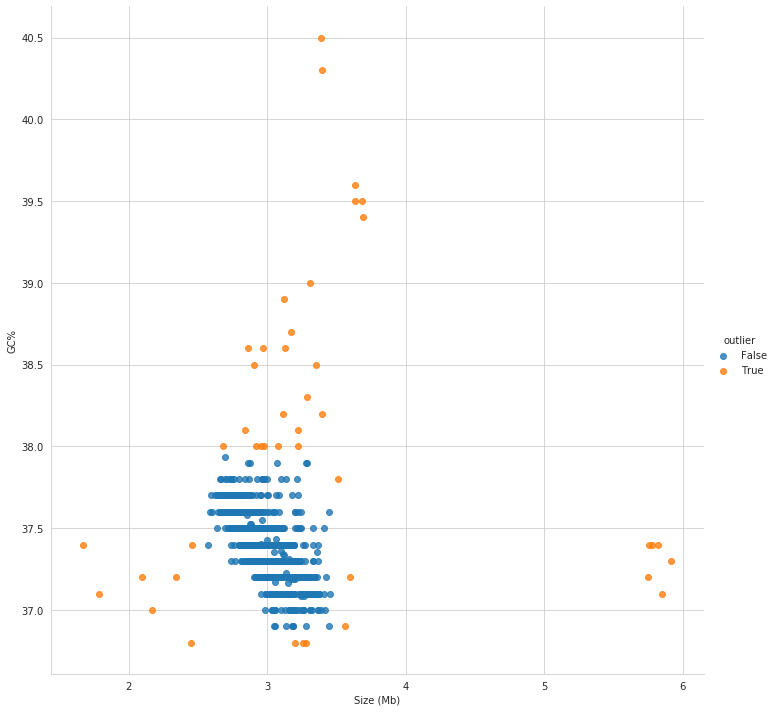

In [19]:
sns.lmplot(data=curated, x="Size (Mb)", y="GC%", fit_reg=False, height=10, hue='outlier')

# N25, N50, N75

Text(0, 0.5, 'number')

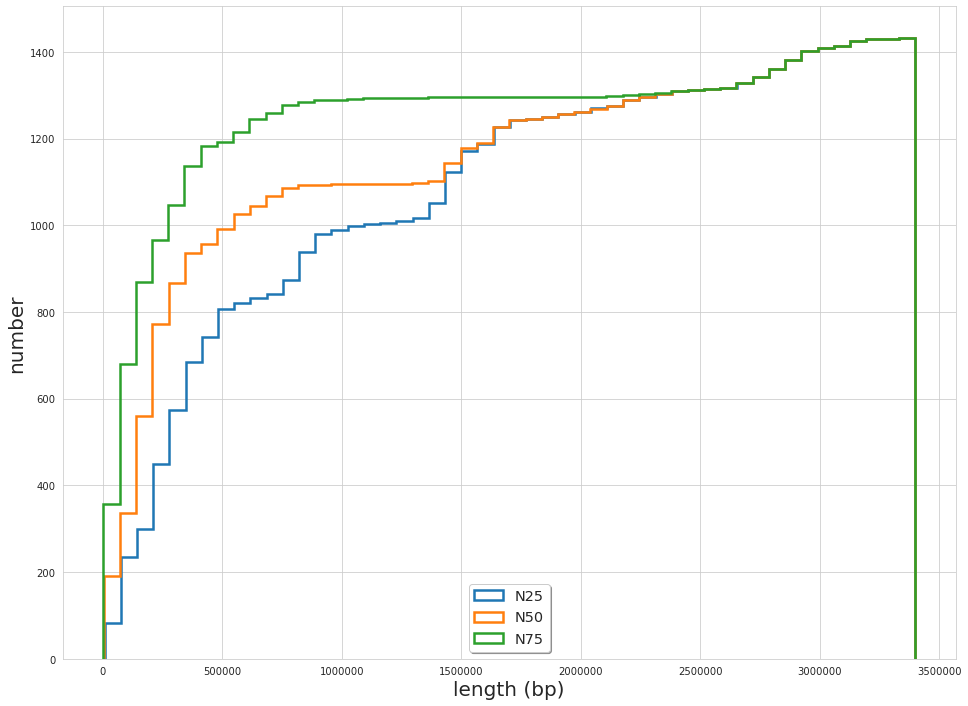

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated["N25"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(curated["N50"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(curated["N75"], bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='lower center', shadow=True, fontsize='x-large')
plt.xlabel("length (bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

Text(0, 0.5, 'number')

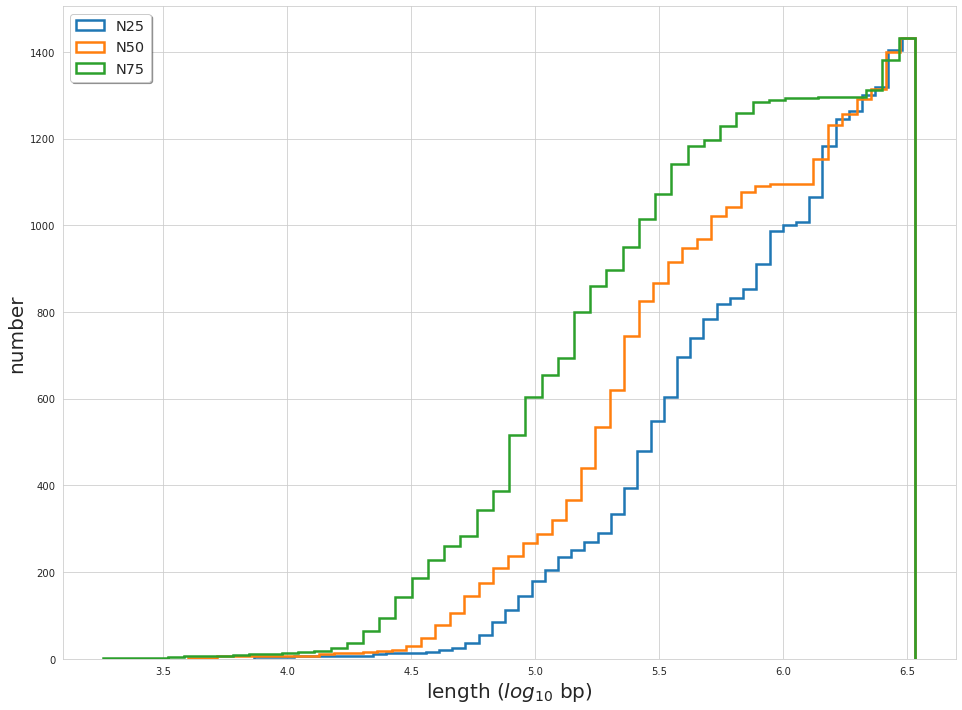

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(np.log10(curated["N25"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N25")
ax.hist(np.log10(curated["N50"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N50")
ax.hist(np.log10(curated["N75"]), bins=50, histtype="step", cumulative=True, lw=2.5, label="N75")
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel("length ($log_{10}$ bp)", fontsize=20)
plt.ylabel("number", fontsize=20)

# comparison with serotypes

In [22]:
curated = curated[curated['N50'] >= 10 ** 6]
curated.shape

(338, 29)

Text(0.5, 1.0, 'Genome contig number distribution')

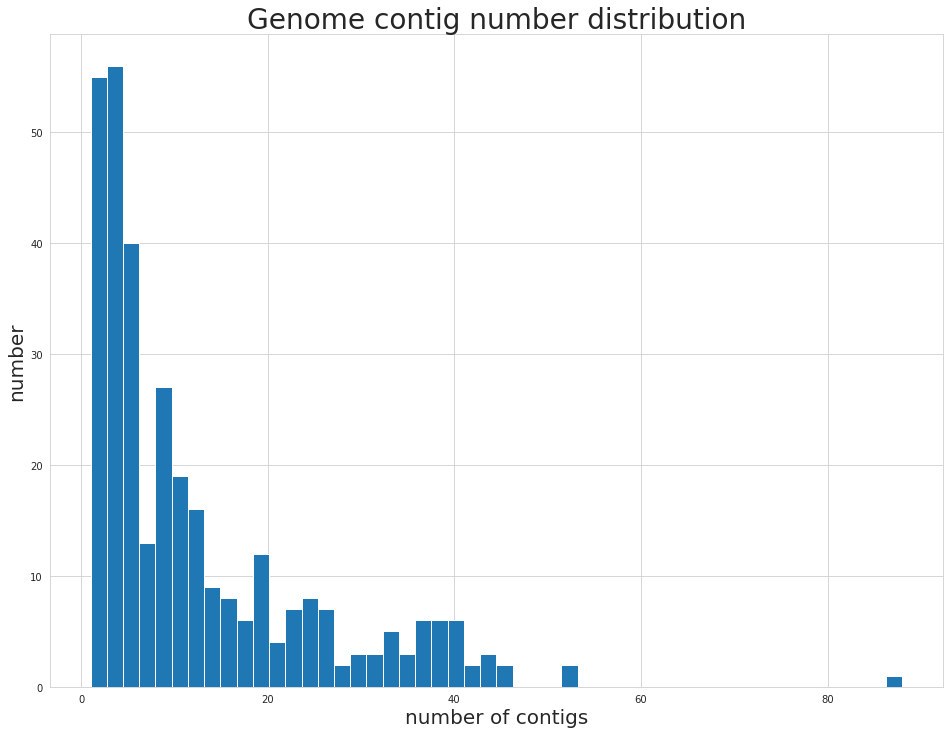

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.hist(curated[~curated['outlier']]["counts"], bins=50)
plt.xlabel("number of contigs", fontsize=20)
plt.ylabel("number", fontsize=20)
plt.title("Genome contig number distribution", fontsize=28)

In [24]:
for i in curated[~curated['outlier']]['id']:
    shutil.copy(os.path.join(path, i+'.fna'), '/media/NGS/Sequence/Enterococcus_faecalis/NCBI_clean')